In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/mask_detection

/content/drive/MyDrive/mask_detection


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import cv2
from tqdm import tqdm
import pandas as pd
import torch
import torchvision
import torchvision.transforms as T

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [ ]:
import pickle
X = pickle.load(open('X.pickle', 'rb'))
y = pickle.load(open('y_1.pickle', 'rb'))

In [ ]:
print(f'X shape : {X.shape}')
print(f'y shape : {y.shape}')

X shape : (20573, 224, 224, 3)
y shape : (20573,)


In [ ]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
X = []
y = []

In [ ]:
# train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, test_size=0.1, random_state=42)

# build model fastrcnn tensorflow

In [ ]:
input_shape = (224, 224, 3)
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
num_classes = 2

In [ ]:
baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=input_shape))

In [ ]:
x = baseModel.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x) # Add dropout layer
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) # Add dropout layer
x = Dense(1, activation='sigmoid')(x)


In [ ]:
for layer in baseModel.layers:
    layer.trainable = False

In [ ]:
# compile our model
fast_rcnn_model = Model(inputs=baseModel.input, outputs=x)
print("[INFO] compiling model...")
fast_rcnn_model.compile(loss="binary_crossentropy", optimizer=Adam(INIT_LR), metrics=["accuracy"])

[INFO] compiling model...


In [ ]:
fast_rcnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
print("[INFO] training head...")
H = fast_rcnn_model.fit( train_X, train_y, batch_size=BS, epochs=EPOCHS, validation_split=0.1)

[INFO] training head...
Epoch 1/20
521/521 [==============================] - 84s 136ms/step - loss: 0.2967 - accuracy: 0.9647 - val_loss: 0.0485 - val_accuracy: 0.9903
Epoch 2/20
521/521 [==============================] - 71s 137ms/step - loss: 0.0610 - accuracy: 0.9885 - val_loss: 0.0980 - val_accuracy: 0.9838
Epoch 3/20
521/521 [==============================] - 71s 137ms/step - loss: 0.0595 - accuracy: 0.9919 - val_loss: 0.0183 - val_accuracy: 0.9951
Epoch 4/20
521/521 [==============================] - 67s 128ms/step - loss: 0.0420 - accuracy: 0.9923 - val_loss: 0.0337 - val_accuracy: 0.9935
Epoch 5/20
521/521 [==============================] - 71s 136ms/step - loss: 0.0300 - accuracy: 0.9950 - val_loss: 0.0319 - val_accuracy: 0.9930
Epoch 6/20
521/521 [==============================] - 71s 136ms/step - loss: 0.0524 - accuracy: 0.9917 - val_loss: 0.0455 - val_accuracy: 0.9930
Epoch 7/20
521/521 [==============================] - 71s 137ms/step - loss: 0.0473 - accuracy: 0.9942 - v

In [ ]:
import tensorflow as tf

tf.keras.models.save_model(fast_rcnn_model, 'my_model_3.h5')


In [ ]:
from sklearn.metrics import confusion_matrix

# Assuming you have a test dataset called test_data and corresponding labels called test_labels
predictions = fast_rcnn_model.predict(test_X)
predicted_labels = predictions > 0.5
cm = confusion_matrix(test_y, predicted_labels)

print('Confusion matrix:')
print(cm)

65/65 [==============================] - 7s 104ms/step
Confusion matrix:
[[1010    2]
 [   3 1043]]


In [ ]:
test_loss, test_accuracy = fast_rcnn_model.evaluate(test_X, test_y)

print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

65/65 [==============================] - 7s 103ms/step - loss: 0.0230 - accuracy: 0.9976
Test loss: 0.02302372269332409
Test accuracy: 0.9975704550743103


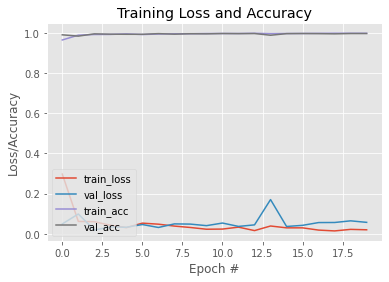

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
